### Text has to be preprocessed to be tokenized by TF-IDF

# Import packages

In [151]:
# Import packages
import pandas as pd
import re 
from gensim.parsing.preprocessing import STOPWORDS, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short
import pickle
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load data

In [50]:
# Load data
df = pd.read_csv('../datasets/distilbert_data/EarningsPerShareDiluted.csv')
df.dropna(inplace=True)
text = df['text']

# Preprocess text

In [51]:
# Remove punctuation
text = text.apply(lambda x: strip_punctuation(x))

# Remove multiple whitespaces
text = text.apply(lambda x: strip_multiple_whitespaces(x))

# Transform to lowercase
text = text.apply(lambda x: x.lower())

# Remove stopwords
text = text.apply(lambda x: remove_stopwords(x))

# Remove short words
text = text.apply(lambda x: strip_short(x))

# Lemmatization

In [52]:
# Initialize spacy en model
nlp = spacy.load('en_core_web_sm')

# Lemmatize text
text_lemma = text.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

print(text[0])

accordingly announced year end financial results fiscal 2015 provided guidance certain assumptions including ranges expected net sales earnings share quarter ending september 2015 fiscal year ending june 2016


# Corpus storage

In [53]:
pickle.dump(text_lemma, open('../datasets/distilbert_data/preprocessed/EarningsPerShareDiluted_preprocessed.pkl', 'wb'))
pickle.dump(text, open('../datasets/distilbert_data/preprocessed/EarningsPerShareDiluted_clean.pkl', 'wb'))

In [89]:
# Specify parameters
min_count = round(len(corpus) * 0.05)
vector_size = 100

# TF-IDF 

In [95]:
# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=min_count)

# Apply tfidf vectorizer
tfidf = tfidf_vectorizer.fit_transform(text_lemma).toarray()

# Final corpus
corpus_tfidf = pd.DataFrame(tfidf)
corpus_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,0.431023,0.175089,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287696
1,0.000000,0.362868,0.164157,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298121
2,0.000000,0.000000,0.331876,0.173560,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301355
3,0.000000,0.000000,0.000000,0.344063,0.192256,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298701
4,0.000000,0.000000,0.000000,0.000000,0.378586,0.194556,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294097


# Doc2Vec

In [67]:
# Split the data into tokens
corpus = [doc.split() for doc in text_lemma]

# Create a gensim dictionary
dictionary = Dictionary(corpus)

# Remove rare and common tokens
dictionary.filter_extremes(no_below=10, no_above=0.95)

# Train the model 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
d2v = Doc2Vec(documents, vector_size=vector_size, min_count=min_count)

# Final corpus
corpus_d2v = pd.DataFrame([d2v.infer_vector(doc) for doc in corpus])
corpus_d2v.head()

In [79]:
# Train the model 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
d2v = Doc2Vec(documents, vector_size=vector_size, min_count=min_count)

# Final corpus
corpus_d2v = pd.DataFrame([d2v.infer_vector(doc) for doc in corpus])
corpus_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.059387,-0.010554,0.074970,0.029473,-0.012303,-0.075058,-0.031920,0.047558,-0.042538,-0.006812,...,0.015518,-0.016669,0.110024,0.082972,0.079165,0.060169,-0.032024,-0.021489,-0.020179,-0.030082
1,-0.056262,-0.009078,0.071133,0.022103,-0.013970,-0.061308,-0.030903,0.033770,-0.035434,-0.004560,...,-0.001515,-0.033771,0.106283,0.084190,0.062245,0.048808,-0.049486,-0.019710,-0.026810,-0.020993
2,-0.052209,-0.013164,0.062283,0.020480,-0.006454,-0.058924,-0.022883,0.037314,-0.033192,-0.007238,...,0.008954,-0.019106,0.087657,0.080449,0.061396,0.047413,-0.032824,-0.025910,-0.016128,-0.015642
3,-0.050562,-0.008628,0.070373,0.014288,-0.011930,-0.058947,-0.037681,0.033945,-0.034250,-0.006683,...,-0.005099,-0.032245,0.102464,0.095816,0.063762,0.043741,-0.055836,-0.017600,-0.025613,-0.014997
4,-0.058458,-0.013427,0.082487,0.014441,-0.017484,-0.060931,-0.040692,0.024879,-0.032765,-0.014018,...,-0.011062,-0.038034,0.112990,0.103496,0.060037,0.045561,-0.069985,-0.017748,-0.030944,-0.013211


In [80]:
pickle.dump(corpus_d2v, open('../datasets/distilbert_data/preprocessed/EarningsPerShareDiluted_D2V.pkl', 'wb'))

# Train model with only text

In [96]:
# Load target to each of the models
corpus_tfidf['target'] = df['test']
corpus_d2v['target'] = df['test']

In [97]:
corpus_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,target
0,0.431023,0.175089,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287696,2.82
1,0.000000,0.362868,0.164157,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298121,2.96
2,0.000000,0.000000,0.331876,0.173560,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301355,3.35
3,0.000000,0.000000,0.000000,0.344063,0.192256,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298701,2.95
4,0.000000,0.000000,0.000000,0.000000,0.378586,0.194556,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294097,4.82


# Test/train split

In [126]:
# Specifiy parameters
random_state = 42

In [148]:
# Split train test data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(corpus_tfidf.drop(['target'], axis=1), corpus_tfidf['target'], test_size=0.2, random_state=random_state)
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(corpus_d2v.drop(['target'], axis=1), corpus_d2v['target'], test_size=0.2, random_state=random_state)

# Random Forest Regressor

In [161]:
# Train the model on TF-IDF features
rf_tfidf = RandomForestRegressor(random_state=random_state)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Train the model on Doc2Vec features
rf_d2v = RandomForestRegressor(random_state=random_state)
rf_d2v.fit(X_train_d2v, y_train_d2v)

# Predict on validation data
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_d2v = rf_d2v.predict(X_test_d2v)

# Evaluate the models
# Function to calculate the relative squared error
# Pros of RSE:
# - It is scale independent --> can be used to compare models with different scales
# - It is symmetric
# - It is easy to interpret --> below 1 means that the model is better than the baseline, above 1 means that the model is worse than the baseline
def rse(y_true, y_pred):
    true_mean = np.mean(y_true)
    squared_error_num = np.sum(np.square(y_true - y_pred))
    squared_error_den = np.sum(np.square(y_true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss  
# Create a dataframe with the results
results = pd.DataFrame({'model': ['TFIDF', 'Doc2Vec'], 
                        'RSE': [rse(y_test_tfidf, y_pred_tfidf), rse(y_test_d2v, y_pred_d2v)]
                        })
results

,model,RSE
0,TFIDF,0.620784
1,Doc2Vec,1.027042


In [ ]:
# Interpret the results
# The model with the lowest RSE is the best model
# In this case, the Doc2Vec model is the best model


Results are not good, hyperparameters tuning required

In [142]:
import warnings
from sklearn.exceptions import FitFailedWarning

# Reset warnings to default behavior
warnings.resetwarnings()
random_forest_tuning_tfidf = RandomForestRegressor(random_state = random_state)
param_grid = {
   'n_estimators': [100, 200, 500],
   'max_features': ['auto','sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8],
   'min_samples_split': [2, 5, 10, 15, 20],
   'min_samples_leaf': [1, 2, 5, 10]
}
# Suppress FitFailedWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FitFailedWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")
#+7+
    
    # Your GridSearchCV code
    GSCV_tfidf = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
    GSCV_tfidf.fit(X_train_tfidf, y_train_tfidf)
    
GSCV_tfidf.best_params_ 

{'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [145]:
# Reset warnings to default behavior
warnings.resetwarnings()
random_forest_tuning_d2v = RandomForestRegressor(random_state = random_state)
param_grid = {
    'n_estimators': [100, 200, 500],
   'max_features': ['auto','sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8],
   'min_samples_split': [2, 5, 10, 15, 20],
   'min_samples_leaf': [1, 2, 5, 10]
}
# Suppress FitFailedWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FitFailedWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

    
    # Your GridSearchCV code
    GSCV_d2v = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
    GSCV_d2v.fit(X_train_d2v, y_train_d2v)
    
GSCV_d2v.best_params_ 

{'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [146]:
# Train the model on TF-IDF features
rf_tfidf = RandomForestRegressor(random_state=random_state, 
                                 max_depth=8, max_features='log2', 
                                 min_samples_leaf=2, min_samples_split=5,
                                 n_estimators=100)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Train the model on Doc2Vec features
rf_d2v = RandomForestRegressor(random_state=random_state, 
                               max_depth=8, max_features='log2', 
                               min_samples_leaf=1, min_samples_split=2,
                               n_estimators=100)
rf_d2v.fit(X_train_d2v, y_train_d2v)

# Predict on validation data
y_pred_test_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_test_d2v = rf_d2v.predict(X_test_d2v)

# Evaluate the models
# Create a dataframe with the results
results = pd.DataFrame({'model': ['TFIDF', 'Doc2Vec'], 
                        'RAE': [mean_absolute_error(y_test_tfidf, y_pred_test_tfidf) / (sum(abs(y_test_tfidf - y_test_tfidf.mean())) / len(y_test_tfidf)), mean_absolute_error(y_test_d2v, y_pred_test_d2v) / (sum(abs(y_test_d2v - y_test_d2v.mean())) / len(y_test_d2v))], # relative absolute error
                        })

results

,model,MSE,MAE,RAE,RMSE,r2_score
0,TFIDF,15.373259,2.091342,0.860600,3.920875,0.147239
1,Doc2Vec,4.313006,1.305175,0.537088,2.076778,0.760756


# Whole process

In [166]:
# Prepare data for training
df['text'] = text_lemma
df = df[['text', 'val']]
df.columns = ['text', 'target'] # Rename columns
df.head()

,text,target
0,accordingly announce year end financial result...,2.82
1,accordingly announce year end financial result...,2.96
2,accordingly announce year end financial result...,3.35
3,accordingly announce year end financial result...,2.95
4,accordingly announce year end financial result...,4.82


In [189]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import make_scorer
from tqdm import tqdm
import time

In [202]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the RSE scoring function
def rse_scorer(y_true, y_pred):
    true_mean = np.mean(y_true)
    squared_error_num = np.sum(np.square(y_true - y_pred))
    squared_error_den = np.sum(np.square(y_true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return -rse_loss  # Note the negative sign since GridSearchCV maximizes the score

# Custom transformer for Doc2Vec
class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=None):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers if workers is not None else multiprocessing.cpu_count()

    def fit(self, X, y=None):
        self.documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.model.build_vocab(self.documents)
        self.model.train(self.documents, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(doc.split()) for doc in X])
    
# Define the pipeline
pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestRegressor(random_state=random_state))
])

pipeline_doc2vec = Pipeline([
    ('doc2vec', Doc2VecTransformer()),
    ('rf', RandomForestRegressor(random_state=random_state))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_features': [1.0, 'sqrt', 'log2'],
    'rf__max_depth': [None, 4, 8],
    'rf__min_samples_split': [2, 10, 20],
    'rf__min_samples_leaf': [1, 5, 10]
}

# Define the vector sizes to try for Doc2Vec
doc2vec_vector_sizes = [50, 100, 200]

# Add timer to record time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FitFailedWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

    # Perform grid search for TF-IDF
    with tqdm(total=len(param_grid['rf__n_estimators']) * len(param_grid['rf__max_features']) *
              len(param_grid['rf__max_depth']) * len(param_grid['rf__min_samples_split']) *
              len(param_grid['rf__min_samples_leaf']), desc='Grid Search Progress - TF-IDF') as pbar:
        
        start_time_tfidf = time.time()  # Record the start time

        grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid, cv=5, scoring=make_scorer(rse_scorer), n_jobs=-1)
        grid_search_tfidf.fit(train_df['text'], train_df['target'])
        
        end_time_tfidf = time.time()  # Record the end time
        elapsed_time_tfidf = end_time_tfidf - start_time_tfidf  # Calculate the elapsed time

        pbar.update(1)  # Update the progress bar
        
    # Access the best parameters and performance metrics for TF-IDF
    print(f"Best parameters for TF-IDF: {grid_search_tfidf.best_params_}")
    print(f"Best negative RSE score for TF-IDF: {grid_search_tfidf.best_score_}")
    print(f"Time taken for TF-IDF grid search: {elapsed_time_tfidf} seconds")
    print("------------------------------------------------------------")
    
    # Perform grid search for Doc2Vec with different vector sizes
    best_doc2vec_vector_size = None
    best_doc2vec_score = float('-inf')  # Initialize with negative infinity
    
    start_time_doc2vec = time.time()  # Record the start time
    for vector_size in tqdm(doc2vec_vector_sizes, desc='Vector Size Progress - Doc2Vec'):
        pipeline_doc2vec.set_params(doc2vec__vector_size=vector_size)
        grid_search_doc2vec = GridSearchCV(pipeline_doc2vec, param_grid, cv=5, scoring=make_scorer(rse_scorer), n_jobs=-1)
        grid_search_doc2vec.fit(train_df['text'], train_df['target'])
        
        # Check if the current vector size has a better score than the previous best
        if grid_search_doc2vec.best_score_ > best_doc2vec_score:
            best_doc2vec_score = grid_search_doc2vec.best_score_
            best_doc2vec_vector_size = vector_size
            best_doc2vec_params = grid_search_doc2vec.best_params_
            best_doc2vec_model = grid_search_doc2vec
            
    
    end_time_doc2vec = time.time()  # Record the end time
    elapsed_time_doc2vec = end_time_doc2vec - start_time_doc2vec  # Calculate the elapsed time

    print(f"Best parameters for Doc2Vec (vector_size={best_doc2vec_vector_size}): {best_doc2vec_params}")
    print(f"Best negative RSE score for Doc2Vec: {best_doc2vec_score} (vector_size={best_doc2vec_vector_size})")
    print(f"Time taken for Doc2Vec grid search: {elapsed_time_doc2vec} seconds")
    print("------------------------------------------------------------")

Grid Search Progress - TF-IDF:   0%|          | 0/243 [00:00<?, ?it/s]

Grid Search Progress - TF-IDF:   0%|          | 1/243 [21:05<85:06:09, 1265.99s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best negative RSE score for TF-IDF: -0.805833257125878
Time taken for TF-IDF grid search: 1265.9904572963715 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec: 100%|██████████| 3/3 [1:38:55<00:00, 1978.41s/it]

Best parameters for Doc2Vec (vector_size=50): {'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for Doc2Vec: -0.8896547563734345 (vector_size=50)
Time taken for Doc2Vec grid search: 5935.244999170303 seconds
------------------------------------------------------------


In [203]:
# Evaluate the models on the test set
y_pred_tfidf = grid_search_tfidf.predict(test_df['text'])
y_pred_d2v = grid_search_doc2vec.predict(test_df['text'])
# Function to calculate the relative squared error
# Pros of RSE:
# - It is scale independent --> can be used to compare models with different scales
# - It is symmetric
# - It is easy to interpret --> below 1 means that the model is better than the baseline, above 1 means that the model is worse than the baseline
def rse(y_true, y_pred):
    return -rse_scorer(y_true, y_pred)  # Reverse the sign of the RSE score to get the RSE

# Train RSE
train_tfidf_score = -1 * grid_search_tfidf.best_score_
train_doc2vec_score = -1 * best_doc2vec_score
# Test RSE
test_tfidf_score = rse(test_df['target'], y_pred_tfidf)
test_doc2vec_score = rse(test_df['target'], y_pred_d2v)

# Create a dataframe with the results
results = pd.DataFrame({'Model': ['TFIDF', 'Doc2Vec'], 
                        'Train RSE': [train_tfidf_score, train_doc2vec_score],
                        'Test RSE': [test_tfidf_score, test_doc2vec_score]
                        })
results


,Model,Train RSE,Test RSE
0,TFIDF,0.805833,0.733966
1,Doc2Vec,0.889655,0.865065


TF-IDF performs better than Doc2Vec in both train and test sets. 

In [206]:
# Save both models
with open('../datasets/distilbert_data/models/EarningsPerShareDiluted/EarningsPerShareDiluted_TFIDF.pkl', 'wb') as f:
    pickle.dump(grid_search_tfidf, f)
with open('../datasets/distilbert_data/models/EarningsPerShareDiluted/EarningsPerShareDiluted_D2V.pkl', 'wb') as f:
    pickle.dump(best_doc2vec_model, f)

## Function to process many models

In [283]:
def train_random_forest_regressor(df, target_column, random_state=42):
    # Split the data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

    # Define the RSE scoring function
    def rse_scorer(y_true, y_pred):
        true_mean = np.mean(y_true)
        squared_error_num = np.sum(np.square(y_true - y_pred))
        squared_error_den = np.sum(np.square(y_true - true_mean))
        rse_loss = squared_error_num / squared_error_den
        return -rse_loss  # Note the negative sign since GridSearchCV maximizes the score

    # Custom transformer for Doc2Vec
    class Doc2VecTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, vector_size=100, window=5, min_count=None, workers=None):
            self.vector_size = vector_size
            self.window = window
            self.min_count = min_count
            self.workers = workers if workers is not None else multiprocessing.cpu_count()

        def fit(self, X, y=None):
            self.documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(X)]
            
            # Set min_count to 5% of the document count if not explicitly provided
            if self.min_count is None:
                self.min_count = round(len(self.documents) * 0.05)
                
            self.model = Doc2Vec(vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=self.workers)
            self.model.build_vocab(self.documents)
            self.model.train(self.documents, total_examples=self.model.corpus_count, epochs=self.model.epochs)
            return self

        def transform(self, X):
            return np.array([self.model.infer_vector(doc.split()) for doc in X])

    # Define the pipeline
    pipeline_tfidf = Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.95, min_df=round(len(train_df) * 0.05))),
        ('rf', RandomForestRegressor(random_state=random_state))
    ])

    pipeline_doc2vec = Pipeline([
        ('doc2vec', Doc2VecTransformer()),
        ('rf', RandomForestRegressor(random_state=random_state))
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'rf__n_estimators': [100, 200, 500],
        'rf__max_features': [1.0, 'sqrt', 'log2'],
        'rf__max_depth': [None, 4, 8],
        'rf__min_samples_split': [2, 10],
        'rf__min_samples_leaf': [1, 5]
    }
    
    # Define the vector sizes to try for Doc2Vec
    doc2vec_vector_sizes = [50, 100, 200]
    
    # Add timer to record time
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

        # Perform grid search for TF-IDF
        with tqdm(total=len(param_grid['rf__n_estimators']) * len(param_grid['rf__max_features']) *
                  len(param_grid['rf__max_depth']) * len(param_grid['rf__min_samples_split']) *
                  len(param_grid['rf__min_samples_leaf']), desc='Grid Search Progress - TF-IDF') as pbar:

            start_time_tfidf = time.time()  # Record the start time

            grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid, cv=5, scoring=make_scorer(rse_scorer), n_jobs=-1)
            grid_search_tfidf.fit(train_df['text'], train_df[target_column])

            end_time_tfidf = time.time()  # Record the end time
            elapsed_time_tfidf = end_time_tfidf - start_time_tfidf  # Calculate the elapsed time

            pbar.update(1)  # Update the progress bar

        # Access the best parameters and performance metrics for TF-IDF
        print(f"Best parameters for TF-IDF: {grid_search_tfidf.best_params_}")
        print(f"Best negative RSE score for TF-IDF: {grid_search_tfidf.best_score_}")
        print(f"Time taken for TF-IDF grid search: {elapsed_time_tfidf} seconds")
        print("------------------------------------------------------------")

        # Perform grid search for Doc2Vec with different vector sizes
        best_doc2vec_vector_size = None
        best_doc2vec_score = float('-inf')  # Initialize with negative infinity

        start_time_doc2vec = time.time()  # Record the start time
        for vector_size in tqdm(doc2vec_vector_sizes, desc='Vector Size Progress - Doc2Vec'):
            pipeline_doc2vec.set_params(doc2vec__vector_size=vector_size)
            grid_search_doc2vec = GridSearchCV(pipeline_doc2vec, param_grid, cv=5, scoring=make_scorer(rse_scorer), n_jobs=-1)
            grid_search_doc2vec.fit(train_df['text'], train_df[target_column])

            # Check if the current vector size has a better score than the previous best
            if grid_search_doc2vec.best_score_ > best_doc2vec_score:
                best_doc2vec_score = grid_search_doc2vec.best_score_
                best_doc2vec_vector_size = vector_size
                best_doc2vec_params = grid_search_doc2vec.best_params_
                best_doc2vec_model = grid_search_doc2vec
                
        end_time_doc2vec = time.time()
        elapsed_time_doc2vec = end_time_doc2vec - start_time_doc2vec
        
        
        print(f"Best parameters for Doc2Vec (vector_size={best_doc2vec_vector_size}): {best_doc2vec_params}")
        print(f"Best negative RSE score for Doc2Vec: {best_doc2vec_score} (vector_size={best_doc2vec_vector_size})")
        print(f"Time taken for Doc2Vec grid search: {elapsed_time_doc2vec} seconds")
        print("------------------------------------------------------------")


    # Evaluate the models on the test set
    y_pred_tfidf = grid_search_tfidf.predict(test_df['text'])
    y_pred_d2v = grid_search_doc2vec.predict(test_df['text'])
    # Function to calculate the relative squared error
    # Pros of RSE:
    # - It is scale independent --> can be used to compare models with different scales
    # - It is symmetric
    # - It is easy to interpret --> below 1 means that the model is better than the baseline, above 1 means that the model is worse than the baseline
    def rse(y_true, y_pred):
        return -rse_scorer(y_true, y_pred)  # Reverse the sign of the RSE score to get the RSE
    
    # Train RSE
    train_tfidf_score = -1 * grid_search_tfidf.best_score_
    train_doc2vec_score = -1 * best_doc2vec_score
    # Test RSE
    test_tfidf_score = rse(test_df[target_column], y_pred_tfidf)
    test_doc2vec_score = rse(test_df[target_column], y_pred_d2v)
    
    # Create a dataframe with the results
    results = pd.DataFrame({'Model': ['TFIDF', 'Doc2Vec'], 
                            'Train RSE': [train_tfidf_score, train_doc2vec_score],
                            'Test RSE': [test_tfidf_score, test_doc2vec_score]
                            })
    print(results)
    return grid_search_tfidf, best_doc2vec_model
        

In [281]:
# Function to preprocess text from distilbert_data folder
def preprocess_text(df, target_column):
    # Remove punctuation
    df['text'] = df['text'].apply(lambda x: strip_punctuation(x))

    # Remove multiple whitespaces
    df['text'] = df['text'].apply(lambda x: strip_multiple_whitespaces(x))

    # Transform to lowercase
    df['text'] = df['text'].apply(lambda x: x.lower())

    # Remove stopwords
    df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

    # Remove short words
    df['text'] = df['text'].apply(lambda x: strip_short(x))

    # Initialize spacy en model
    nlp = spacy.load('en_core_web_sm')

    # Lemmatize text
    df['text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    # Prepare data for training
    df = df[['text', target_column]]
    df.columns = ['text', 'target'] # Rename columns
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df


In [266]:
import seaborn as sns
import matplotlib.pyplot as plt

Dataset: EarningsPerShareDiluted


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 27


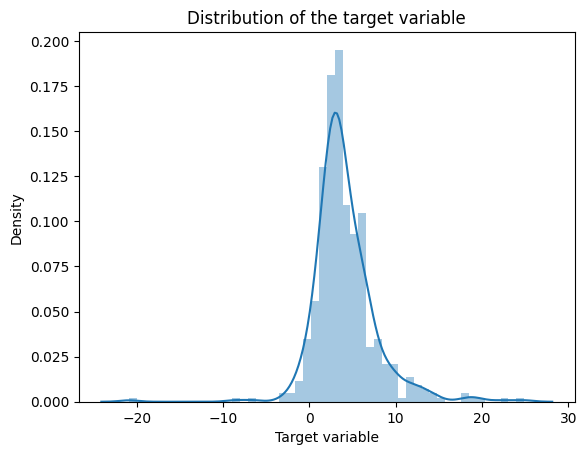

-------------------------//----------------------------
Dataset: EBIT


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 13


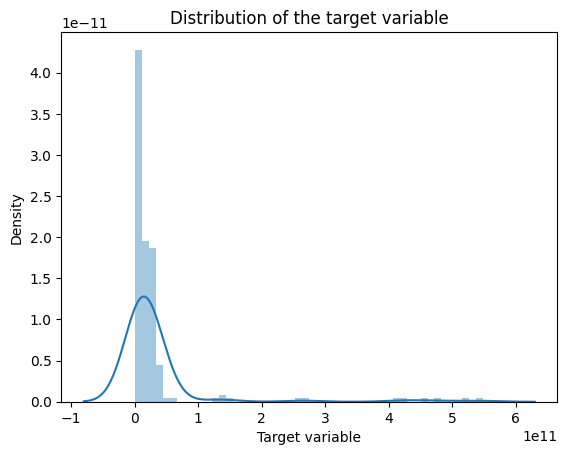

-------------------------//----------------------------
Dataset: NetCashProvidedByUsedInFinancingActivities


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 1


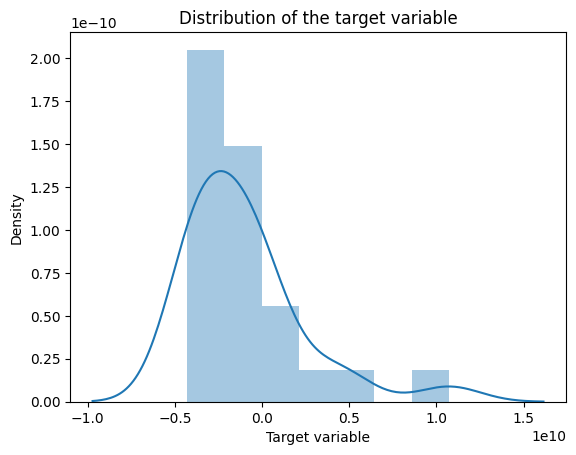

-------------------------//----------------------------
Dataset: NetCashProvidedByUsedInInvestingActivities


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 2


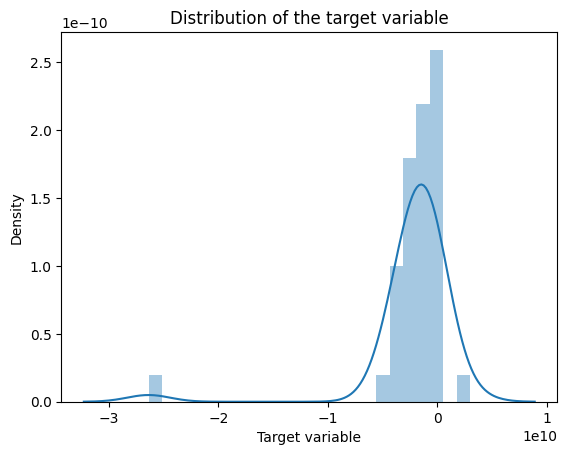

-------------------------//----------------------------
Dataset: NetIncomeLoss


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 1503


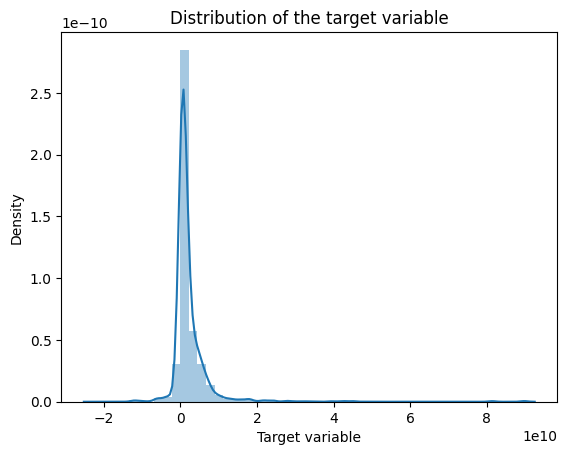

-------------------------//----------------------------
Dataset: RevenueFromContractWithCustomerExcludingAssessedTax


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\2670071631.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


-------------------------//----------------------------
Number of outliers: 971


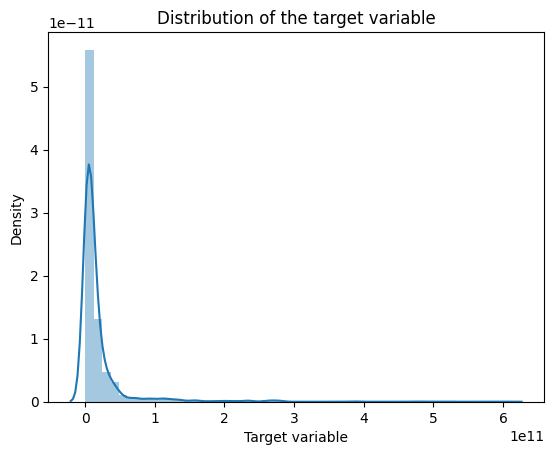

-------------------------//----------------------------


In [279]:
# Get all csv files from distilbert_data folder
path = '../datasets/distilbert_data/'
all_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Loop through all csv files
for file in all_files:
    # Read csv file
    df = pd.read_csv(path + file)
    
    print(f"Dataset: {file.split('.')[0]}")
    # Preprocess text
    df = preprocess_text(df, 'val')
    data = df['target']
    

    # Calculate quartiles
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25

    # Define the outlier boundaries
    lower_bound = q25 - (1.5 * iqr)
    upper_bound = q75 + (1.5 * iqr)

    # Identify outliers using IQR
    outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    print("-------------------------//----------------------------")
    print("Number of outliers:", len(outliers))

    # Plot the distribution of the target variable
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    sns.distplot(data)
    plt.title('Distribution of the target variable')
    plt.xlabel('Target variable')
    plt.ylabel('Density')
    plt.show()
    
    # Remove outliers
    df.drop(outliers, inplace=True)
    
    
    # Save the preprocessed data
    df.to_csv(path + 'preprocessed/' + file, index=False)
    
    print("-------------------------//----------------------------")

Dataset: EarningsPerShareDiluted
count    443.000000
mean       3.702190
std        2.376951
min       -2.720000
25%        2.135000
50%        3.400000
75%        5.230000
max       10.240000
Name: target, dtype: float64


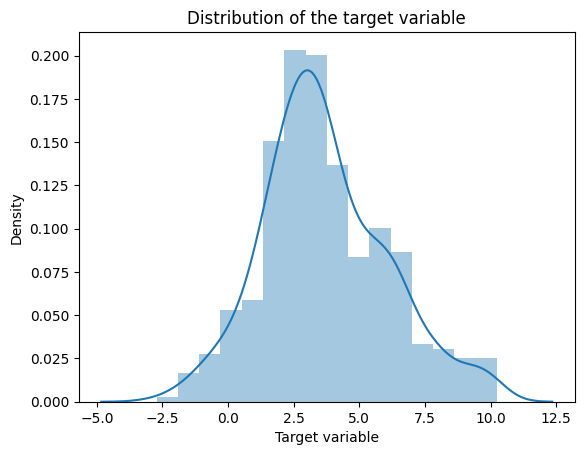

Dataset: EBIT
count    2.110000e+02
mean     1.521919e+10
std      1.128850e+10
min      1.273600e+09
25%      5.186700e+09
50%      1.223100e+10
75%      2.495250e+10
max      4.913378e+10
Name: target, dtype: float64


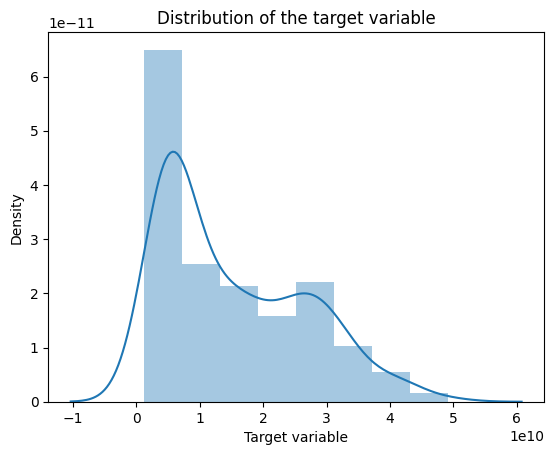

Dataset: NetCashProvidedByUsedInFinancingActivities
count    2.400000e+01
mean    -1.518627e+09
std      2.462028e+09
min     -4.305000e+09
25%     -3.557250e+09
50%     -1.456700e+09
75%     -6.289500e+08
max      4.568000e+09
Name: target, dtype: float64


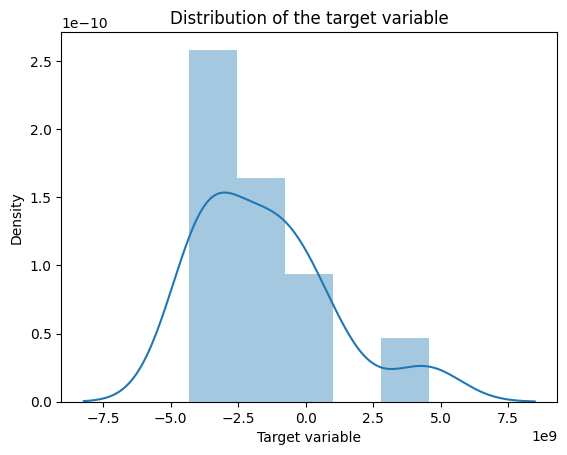

Dataset: NetCashProvidedByUsedInInvestingActivities
count    3.900000e+01
mean    -1.681627e+09
std      1.305169e+09
min     -4.835000e+09
25%     -2.661450e+09
50%     -1.186000e+09
75%     -5.920000e+08
max      3.100000e+07
Name: target, dtype: float64


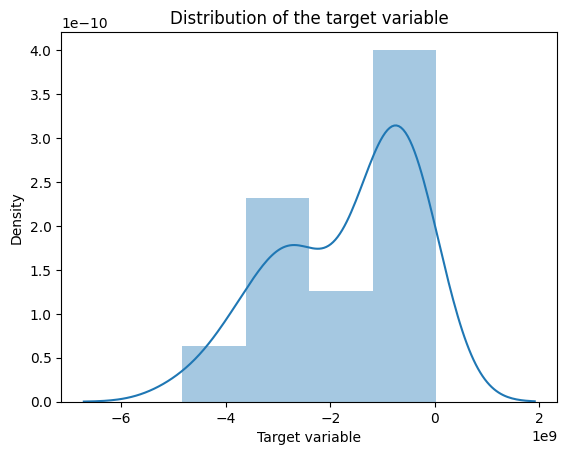

Dataset: NetIncomeLoss
count    1.139500e+04
mean     1.335061e+09
std      1.430857e+09
min     -2.701000e+09
25%      3.831000e+08
50%      8.730000e+08
75%      1.849052e+09
max      5.642000e+09
Name: target, dtype: float64


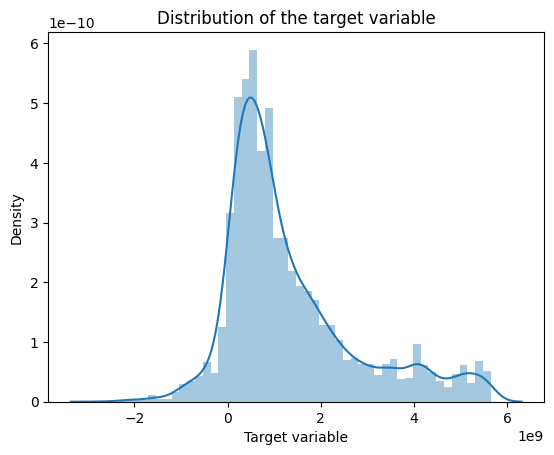

Dataset: RevenueFromContractWithCustomerExcludingAssessedTax
count    7.879000e+03
mean     8.357561e+09
std      7.566904e+09
min      3.084000e+06
25%      2.532800e+09
50%      5.998545e+09
75%      1.174345e+10
max      3.435000e+10
Name: target, dtype: float64


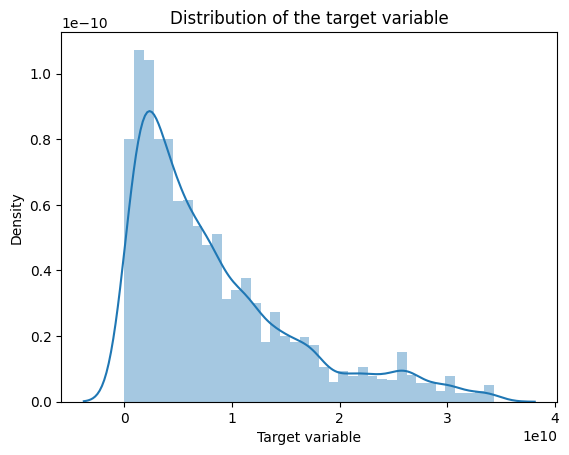

In [282]:
# Get preprocesseed csv files from distilbert_data folder
path = '../datasets/distilbert_data/preprocessed/'
all_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Loop through all csv files
for file in all_files: 
    # Read csv file
    df = pd.read_csv(path + file)
    
    print(f"Dataset: {file.split('.')[0]}")
    
    # Describe the target variable
    print(df['target'].describe())
    
    # Plot the distribution of the target variable
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    sns.distplot(df['target'])
    plt.title('Distribution of the target variable')
    plt.xlabel('Target variable')
    plt.ylabel('Density')
    plt.show()

In [258]:
# Get csv files from distilbert_data folder and preprocess them
import os
import pandas as pd
import pickle
import warnings

# Get all csv files from distilbert_data folder
path = '../datasets/distilbert_data/'
all_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Loop through all csv files
for file in all_files:
    # Read csv file
    df = pd.read_csv(path + file)
    
    # Preprocess text
    df = preprocess_text(df, 'val')
    
    # Train models
    train_random_forest_regressor(df, 'target')
    
    # Save models
    metric_name = file.split('.')[0]
    # If folder not available, create folder
    if not os.path.exists('../models/random_forest/' + metric_name):
        os.makedirs('../models/random_forest/' + metric_name)
    # Save models to folder
    with open('../models/random_forest/' + metric_name + "/" + metric_name + '_TF-IDF.pkl', 'wb') as f:
        pickle.dump(grid_search_tfidf, f)
    with open('../models/random_forest/' + metric_name + "/" + metric_name + '_D2V.pkl', 'wb') as f:
        pickle.dump(best_doc2vec_model, f)
    
    print(f"Models for {metric_name} saved successfully!")

C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\3932386861.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Grid Search Progress - TF-IDF:   0%|          | 1/243 [08:25<34:00:47, 505.98s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -0.8481209570527763
Time taken for TF-IDF grid search: 505.98020577430725 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec: 100%|██████████| 3/3 [1:57:39<00:00, 2353.27s/it]


Best parameters for Doc2Vec (vector_size=200): {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 500}
Best negative RSE score for Doc2Vec: -0.9005984868471616 (vector_size=200)
Time taken for Doc2Vec grid search: 7059.816433668137 seconds
------------------------------------------------------------
     Model  Train RSE  Test RSE
0    TFIDF   0.848121  0.811405
1  Doc2Vec   0.900598  0.967221
Models for EarningsPerShareDiluted saved successfully!


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\3932386861.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Grid Search Progress - TF-IDF:   0%|          | 1/243 [04:43<19:02:49, 283.34s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -0.5765472490615977
Time taken for TF-IDF grid search: 283.3434717655182 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec: 100%|██████████| 3/3 [42:47<00:00, 855.79s/it]


Best parameters for Doc2Vec (vector_size=200): {'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for Doc2Vec: -0.6338268022621952 (vector_size=200)
Time taken for Doc2Vec grid search: 2567.363293647766 seconds
------------------------------------------------------------
     Model  Train RSE  Test RSE
0    TFIDF   0.576547  0.114630
1  Doc2Vec   0.633827  0.443887
Models for EBIT saved successfully!


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\3932386861.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Grid Search Progress - TF-IDF:   0%|          | 1/243 [02:32<10:16:12, 152.78s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -1.0028285489670004
Time taken for TF-IDF grid search: 152.7796835899353 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec: 100%|██████████| 3/3 [09:16<00:00, 185.37s/it]


Best parameters for Doc2Vec (vector_size=50): {'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best negative RSE score for Doc2Vec: -0.9578032246476649 (vector_size=50)
Time taken for Doc2Vec grid search: 556.1328551769257 seconds
------------------------------------------------------------
     Model  Train RSE  Test RSE
0    TFIDF   1.002829  0.995638
1  Doc2Vec   0.957803  0.963406
Models for NetCashProvidedByUsedInFinancingActivities saved successfully!


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\3932386861.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Grid Search Progress - TF-IDF:   0%|          | 1/243 [02:47<11:17:10, 167.89s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best negative RSE score for TF-IDF: -1.4015521093630556
Time taken for TF-IDF grid search: 167.89209604263306 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec: 100%|██████████| 3/3 [10:36<00:00, 212.15s/it]


Best parameters for Doc2Vec (vector_size=100): {'rf__max_depth': 8, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 20, 'rf__n_estimators': 500}
Best negative RSE score for Doc2Vec: -1.3966988238642348 (vector_size=100)
Time taken for Doc2Vec grid search: 636.4457056522369 seconds
------------------------------------------------------------
     Model  Train RSE  Test RSE
0    TFIDF   1.401552  1.078745
1  Doc2Vec   1.396699  1.325981
Models for NetCashProvidedByUsedInInvestingActivities saved successfully!


C:\Users\Khanh Le Nguyen\AppData\Local\Temp\ipykernel_10408\3932386861.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Grid Search Progress - TF-IDF:   0%|          | 1/243 [3:54:21<945:15:00, 14061.57s/it]


Best parameters for TF-IDF: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best negative RSE score for TF-IDF: -0.6081346890113337
Time taken for TF-IDF grid search: 14061.573473215103 seconds
------------------------------------------------------------


Vector Size Progress - Doc2Vec:  33%|███▎      | 1/3 [14:19:08<28:38:16, 51548.07s/it]


KeyboardInterrupt: 

In [257]:
file.split('.')[0]

'EarningsPerShareDiluted'

In [255]:
file.split('/')[-1].split('.')[0]

'EarningsPerShareDiluted'

In [253]:
# Get all csv files from distilbert_data folder
path = '../datasets/distilbert_data/'
all_files = [file for file in os.listdir(path) if file.endswith('.csv')]
all_files[0]

file = path + all_files[0]

'../models/random_forest/' + file.split('/')[-1].split('.')[0] + "/" + file.split('/')[-1].split('.')[0] + '_D2V.pkl'

'../models/random_forest/EarningsPerShareDiluted/EarningsPerShareDiluted_D2V.pkl'

In [229]:
[file for file in os.listdir(path) if file.endswith('.csv')]

['EarningsPerShareDiluted.csv',
 'EBIT.csv',
 'NetCashProvidedByUsedInFinancingActivities.csv',
 'NetCashProvidedByUsedInInvestingActivities.csv',
 'NetIncomeLoss.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax.csv']

In [224]:
file

'../datasets/distilbert_data\\EarningsPerShareDiluted.csv'